<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Introduction to FACET

***

**Robust and impactful Data Science with FACET**

FACET enables us to perform several critical steps in best practice Data Science work flow easily, efficiently and reproducibly:

1. Create a robust pipeline for learner selection using LearnerRanker and cross-validation.

2. Enhance our model inspection to understand drivers of predictions using local explanations of features via [SHAP values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) by applying a novel methodology that decomposes SHAP values into measures of synergy, redundancy, and independence between each pair of features.

3. Quickly apply historical simulation to gain key insights into feature values that minimize or maximize the predicted outcome.

***

**Context**

Drilling a water well is dangerous and costly. Costs are driven by the time it takes to finalize a well in order to start pumping water from it. In order to reduce those costs, drillers are usually incentivised to drill at a faster pace. However, drilling faster increases risks of incident which is the reason why the Rate of Penetration (ROP) is a measure constantly monitored.

Utilizing FACET, we will:

1. Apply use machine learning to prevent a water well drilling operation from an incident.
2. Quantify how the ROP impacts the estimated risk.  

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Data and initial feature selection](#Data-and-initial-feature-selection)
3. [Selecting a learner using FACET ranker](#Selecting-a-learner-using-FACET-ranker)
4. [Using the FACET inspector for model inspection](#Using-the-FACET-inspector-for-model-inspection)
5. [FACET univariate simulator: the impact of rate of penetration](#FACET-univariate-simulator:-the-impact-of-rate-of-penetration)
6. [Appendix](#Appendix)

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os

    if "cwd" not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")


def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook

    # ignore a useless LGBM warning
    import warnings

    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")


_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings


import matplotlib.pyplot as plt


def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

working dir is '/Users/grisard_malo/PycharmProjects/githubFacet/facet'
added `/Users/grisard_malo/PycharmProjects/githubFacet/pytools/src` to python paths
added `/Users/grisard_malo/PycharmProjects/githubFacet/facet/src` to python paths
added `/Users/grisard_malo/PycharmProjects/githubFacet/sklearndf/src` to python paths


# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. Other BCG Gamma packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)) and support visualization (pytools, see on [GitHub](https://github.com/BCG-Gamma/pytools)) when using FACET

**Common package imports**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold

**Gamma FACET imports**

In [3]:
from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer
from facet.crossfit import LearnerCrossfit

inheritdoc:no match found for docstring '[see superclass' in class LearnerRanker


**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [4]:
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF

**pytools imports**

pytools (see on [GitHub](https://github.com/BCG-Gamma/pytools)) is an open source library containing general machine learning and visualization utilities, some of which are useful for visualising the advanced model inspection capabilities of FACET.

In [5]:
import sklearn
import sklearndf

In [6]:
sklearn.ensemble.RandomForestClassifier
sklearndf.classification.GradientBoostingClassifierDF

sklearndf.classification._classification.GradientBoostingClassifierDF

In [7]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

# Data and initial feature selection

For the sake of simplicity, we use a simplified artificial dataset, it contains 500 observations, each row representing a drilling operation of the past, the target is the occurrence of drill breakdown (incident). Details and the code used to simulate this dataset can be found in the [Appendix](#Appendix).

In [8]:
# load the prepared dataframe
df = pd.read_csv(
    "sphinx/source/tutorial/water_drill_data_classification.csv",
    sep=";",
    encoding="utf-8",
)

# quick look
df.head()

,Weight on bit (kg),Rotation speed (rpm),Depth of operation (m),Mud density (kg/L),Rate of Penetration (ft/h),Linear4,Mud Flow in (m3/s),Nonlinear2,Nonlinear3,Temperature (C),Hole diameter (m),Incident,Inverse Rate of Penetration (h/ft)
0,306.141821,9849.952938,927.968837,2.902467,10.000000,-0.385633,50.299606,0.793721,0.153503,34.516570,6.373932,0.0,0.100000
1,324.039405,10744.516916,1106.187754,2.106770,32.898796,0.199908,72.140061,0.155269,0.767234,41.861162,7.507640,1.0,0.030396
2,345.377055,5393.241061,898.168085,3.909455,22.723761,0.647058,10.908230,0.598722,0.101157,58.560955,6.180673,0.0,0.044007
3,356.709497,6776.865696,769.165223,2.473607,25.168914,-0.419456,51.029350,0.588158,0.464393,72.925042,5.368265,1.0,0.039732
4,328.437275,6024.116387,215.202605,3.033681,18.921436,0.006490,44.159394,0.278210,0.190692,43.992966,2.092908,0.0,0.052850


In [9]:
# create a FACET sample object
drilling_obs = Sample(observations=df, target_name="Incident")

Next, we perform some initial feature selection using Boruta, a recent approach shown to have quite good performance. The Boruta algorithm removes features that are no more predictive than random noise. If you are interested further, please see this  [article](https://www.jstatsoft.org/article/view/v036i11).

The `BorutaDF` transformer in our sklearndf package provides easy access to this powerful method. The approach relies on a tree-based learner, usually a random forest. For settings, a `max_depth` of between 3 and 7 is typically recommended, and here we rely on the default setting of 5. However, as this depends on the number of features and the complexity of interactions one could also explore the sensitivity of feature selection to this parameter. The number of trees is automatically managed by the Boruta feature selector argument `n_estimators="auto"`.

We also use parallelization for the random forest using `n_jobs` to accelerate the Boruta iterations.

In [10]:
df.columns

Index(['Weight on bit (kg)', 'Rotation speed (rpm)', 'Depth of operation (m)',
       'Mud density (kg/L)', 'Rate of Penetration (ft/h)', 'Linear4',
       'Mud Flow in (m3/s)', 'Nonlinear2', 'Nonlinear3', 'Temperature (C)',
       'Hole diameter (m)', 'Incident', 'Inverse Rate of Penetration (h/ft)'],
      dtype='object')

In [11]:
# wrapper class to implement Boruta feature selection
feature_selector = BorutaDF(
    estimator=RandomForestClassifierDF(max_depth=5, random_state=42, n_jobs=-3),
    n_estimators="auto",
    random_state=42,
    verbose=0,
    max_iter=200,
)

# create a pipeline that includes some simple preprocessing (imputation) and Boruta
feature_preprocessing = PipelineDF(
    steps=[("impute", SimpleImputerDF()), ("feature selection", feature_selector)]
)

# run feature selection using Boruta and report those selected
feature_preprocessing.fit(X=drilling_obs.features, y=drilling_obs.target)
print(f"Selected features: {list(feature_preprocessing.feature_names_original_.unique())}")

Selected features: ['Weight on bit (kg)', 'Rotation speed (rpm)', 'Depth of operation (m)', 'Mud density (kg/L)', 'Rate of Penetration (ft/h)', 'Hole diameter (m)', 'Inverse Rate of Penetration (h/ft)']


We can see that the key features that we would expect to impact the safety of the operation are included after the feature selection. A working hypothesis of how each influences the target is: 

- **Weight on bit**: we expect higher weight to increase the likelihood of a failure due to heavier equipment wear

- **Rotation speed**: Too fast rotation speed can lead to overheating and breaking the material, too low rotation renders drilling more difficult and is not economical

- **Depth of operation**: As a simplification we will take for granted that the deeper we dig, the denser the soil will be, increasing the likelihood of either a collapse or breaking equipment wear 

- **Hole diameter**: Thinner wholes are used in deeper sections of the well hence usually relate to more dangerous zones

- **Rate of Penetration**: A higher ROP leads to more wear & tear of the equipment and thus we expect a positive effect

- **Inverse Rate of Penetration**: As described by its name, this feature is the inverse of the ROP

- **Mud density**: Mud density needs to match soil density to avoid well collapse (formation falling in well and blocking pipe) or mud loss (mud flowing in the formation)

In [12]:
feature_preprocessing.feature_names_original_.unique()

array(['Weight on bit (kg)', 'Rotation speed (rpm)',
       'Depth of operation (m)', 'Mud density (kg/L)',
       'Rate of Penetration (ft/h)', 'Hole diameter (m)',
       'Inverse Rate of Penetration (h/ft)'], dtype=object)

In [13]:
# create a FACET sample object with features selected by Boruta
drilling_obs_reduced_featset = drilling_obs.keep(feature_names=
    feature_preprocessing.feature_names_original_.unique()
)

# Selecting a learner using FACET ranker

FACET implements several additional useful wrappers which further simplify comparing and tuning a larger number of models and configurations: 

- `LearnerGrid`: allows you to pass a learner pipeline (i.e., classifier + any preprocessing) and a set of hyperparameters
- `LearnerRanker`: multiple LearnerGrids can be passed into this class as a list - this allows tuning hyperparameters both across different types of learners in a single step and ranks the resulting models accordingly

The following learners and hyperparameter ranges will be assessed using 5 repeated 5-fold cross-validation:


1. **Random forest**: with hyperparameters
    - min_samples_leaf: [8, 11, 15]

  
2. **Light gradient boosting**: with hyperparameters
    - min_samples_leaf: [8, 11, 15]

Note if you want to see a list of hyperparameters you can use `classifier_name().get_params().keys()` where `classifier_name` could be for example `RandomForestClassifierDF` and if you want to see the default values, just use `classifier_name().get_params()`.

Note that ranking uses the average performance minus two times the standard deviation, so that we consider both the average performance and variability when selecting a classifier. The default scoring metric for classification is accuracy.

First, we specify the classifiers we want to train using `ClassifierPipelineDF` from sklearndf. Note here we also include feature preprocessing steps.

In [14]:
# random forest learner
rforest_clf = ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(n_estimators=500, random_state=42),
)

# light gradient boosting learner
lgbm_clf = ClassifierPipelineDF(
    classifier=LGBMClassifierDF(random_state=42),
)

Then we create a list of learner grids where each learner grid is created using `LearnerGrid` and allows us to associate a `ClassifierPipelineDF` with a specified set of hyperparameter via the `learner_parameters` argument. Note this structure allows us to easily include additional classifiers and hyperparameters.

In [15]:
# define learner grid
clf_grid = [
    LearnerGrid(
        pipeline=rforest_clf, learner_parameters={"min_samples_leaf": [8, 11, 15]}
    ),
    LearnerGrid(
        pipeline=lgbm_clf, learner_parameters={"min_data_in_leaf": [8, 11, 15]}
    ),
]

We now fit the grid defined above using the `LeanerRanker`, which will run a gridsearch (or random search if defined) using 5 repeated 5-fold cross-validation.

In [16]:
# create cv iterator 5 repeated 5-fold
cv_approach = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# fit ranker
model_ranker = LearnerRanker(grids=clf_grid, cv=cv_approach, n_jobs=-3).fit(
    sample=drilling_obs_reduced_featset
)

To see the configuration of the best selected model, we can access the `best_model_` property of the fitted `LearnerRanker` object.

In [17]:
model_ranker.best_model_

ClassifierPipelineDF(classifier=LGBMClassifierDF(min_data_in_leaf=15,
                                                 random_state=42))

We can see how each model scored using the `summary_report()` method of the `LearnerRanker`.

In [18]:
# let's look at performance for the top ranked classifiers
model_ranker.summary_report()

ranking_score accuracy_score                      \
                             mean       std       sem   
rank                                                    
0         0.805611         0.8676  0.030995  0.006199   
1         0.797133         0.8616  0.032234  0.006447   
2         0.784660         0.8596  0.037470  0.007494   
3         0.701161         0.7508  0.024819  0.004964   
4         0.699447         0.7600  0.030277  0.006055   
5         0.695836         0.7532  0.028682  0.005736   

                    classifier                                    
                          type min_samples_leaf min_data_in_leaf  
rank                                                              
0             LGBMClassifierDF              NaN             15.0  
1             LGBMClassifierDF              NaN             11.0  
2             LGBMClassifierDF              NaN              8.0  
3     RandomForestClassifierDF             15.0              NaN  
4     RandomForestClassifierDF              8.0              NaN  
5     RandomForestClassifierDF             11.0              NaN

# Using the FACET inspector for model inspection

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for a given observation. SHAP values are computed for every feature and observation.

The FACET `LearnerInspector` computes SHAP values for each crossfit (i.e., a CV fold or bootstrap resample) using the best model identified by the `LearnerRanker`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding feature redundancy and synergy. Redundancy and synergy are calculated using the new algorithm FACET implements for using SHAP values to understand model predictions.

The definitions are as follows:

- **Redundancy** represents how much information is shared between two features contributions to the model predictions. For example, given features X and Y as coordinates on a chess board, the colour of a square can only be predicted when considering X and Y in combination. Redundancy is expressed as a percentage ranging from 0% (full uniqueness) to 100% (full redundancy).


- **Synergy** represents how much the combined information of two features contributes to the model predictions. For example, temperature and pressure in a pressure cooker are redundant features for predicting cooking time since pressure will rise relative to the temperature, and vice versa. Therefore, knowing just one of either temperature or pressure will likely enable the same predictive accuracy. Synergy is expressed as a percentage ranging from 0% (full autonomy) to 100% (full synergy).

Both cases can apply at the same time, i.e. a pair of features can use some information synergistically while using other information redundantly.

To analyse redundancy for all possible feature parings, the approach is:

1.	Calculate the feature redundancy matrix using SHAP value decomposition - this gives us pairwise redundancy between features, in the range of 0.0 (fully unique contributions) and 1.0 (fully redundant contributions)
2.	Transform the feature redundancy matrix into a feature distance matrix, where distance is expressed as (1.0 - redundancy)
3.	Perform hierarchical, single-linkage clustering on the distance matrix, thus identifying groups of low-distance, redundant features which activate “in tandem” to predict the outcome

The same approach can be used to analyse synergy.

The inspector can calculate all of this with a single method call, but also offers methods to access the intermediate results of each step. A lightweight visualization framework is available to render the results in different styles.

SHAP values from the `LearnerInspector` can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

In [19]:
model_inspector = LearnerInspector(n_jobs=-3)
model_inspector.fit(crossfit=model_ranker.best_model_crossfit_)

redundancy_matrix = model_inspector.feature_redundancy_matrix()
synergy_matrix = model_inspector.feature_synergy_matrix()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


**Feature redundancy**

When plotting out the feature redundancy, we can see that there are some features which contain the same information to the model. In this case, these features are the depth of the operation and the hole diameter. 
Intuitively, we can see why these two features are redundant, as the depth of operation and the hole diameter are highly connected as drillers use thinner drilling bits as they drill deeper into the earth.

As we don't want either of the features to confuse the model inference during the simulation step, we should **remove the hole diameter** for this example. 
We also observe an expected redundancy between ROP and Inverse Rate of Penetration (IROP), as the IROP is just the inverse of the ROP. We should **remove the IROP** as well.

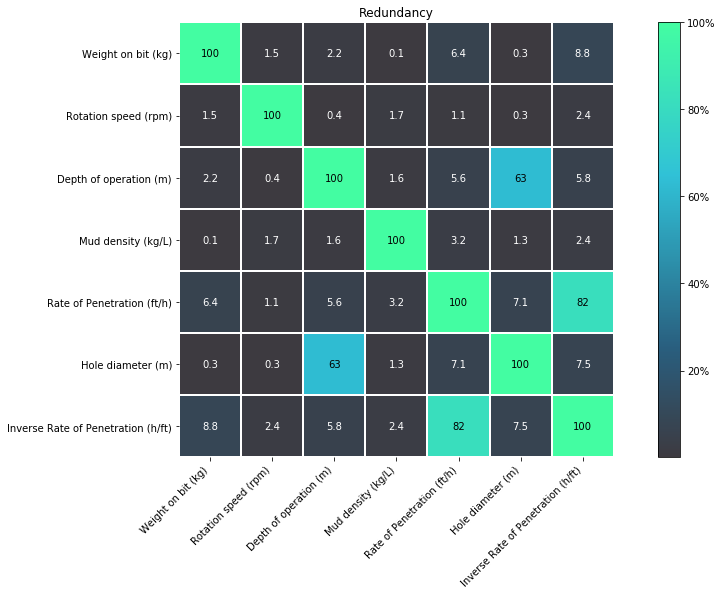

In [20]:
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy")

**Feature synergy**

When looking at the synergy matrix, we can easily figure out which of the features have an interaction effect on the target. We see that the **weight on the bit and the rotation speed in combination appear to have a high synergy.** Those two features are also synergistic with the ROP, which makes sense as the ROP is a consequence of the weight on bit and rotation speed that is applied.

In hindsight, this appears obvious - drilling with both high bit weight and a high pace can have a disproportionately large impact on the wear of the equipment, thus drastically to higher failure likelihood.

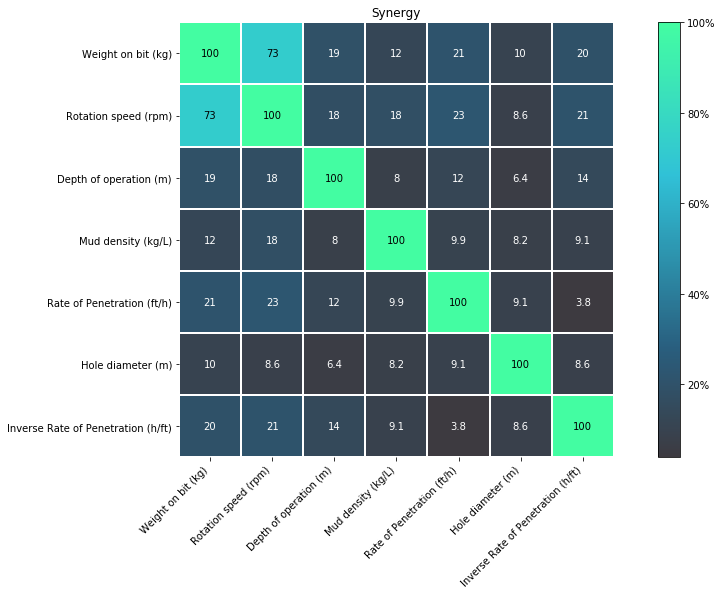

In [21]:
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

**Removing redundant features**

As the picture above shows a high redundancy level between the **ROP** and the **IROP**, both features compete in terms of feature importance. The dendrogram below shows that **ROP** should be favoured though to orthogonalise the feature set before simulation. 
**Hole diameter** and **Depth of Operation** share also a high level of redundancy but the latter seems to hold more feature importance hence it is the **hole diameter** that will be removed to orthogonalise the feature set before simulation.

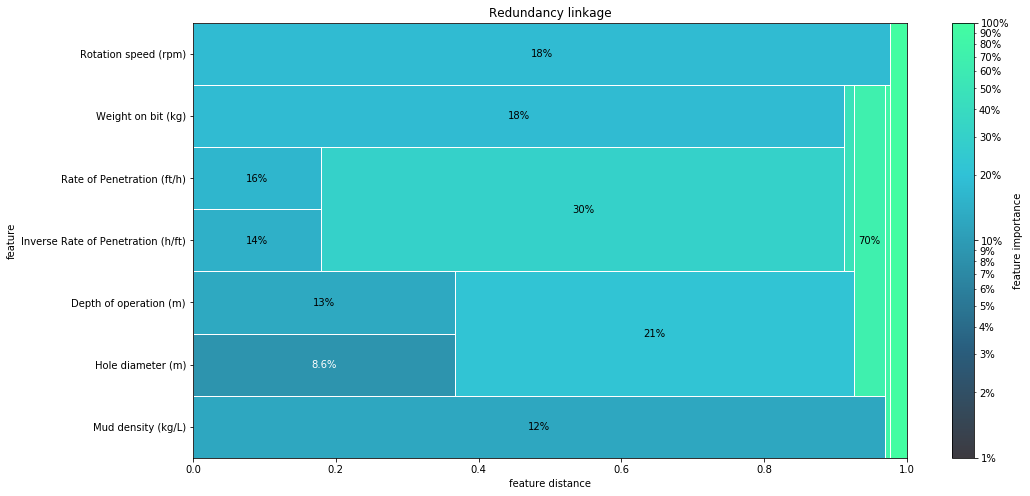

In [22]:
redundancy = model_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

In order to use the univariate simulator, we need to have an orthogonal set of features. This is needed such that artificially created samples stay plausible. Indeed, not removing the Inverse Rate of Penetration feature from the set would lead to unrealistic artificial observations while using the univariate simulator.

In [23]:
# remove redundant features
redundant_features = ["Inverse Rate of Penetration (h/ft)"]
drilling_obs_not_redundant = drilling_obs_reduced_featset.drop(feature_names=redundant_features)

model_ranker = LearnerRanker(grids=clf_grid, cv=cv_approach, n_jobs=-3).fit(
    sample=drilling_obs_not_redundant
)

model_inspector = LearnerInspector(n_jobs=-3)
model_inspector.fit(crossfit=model_ranker.best_model_crossfit_)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


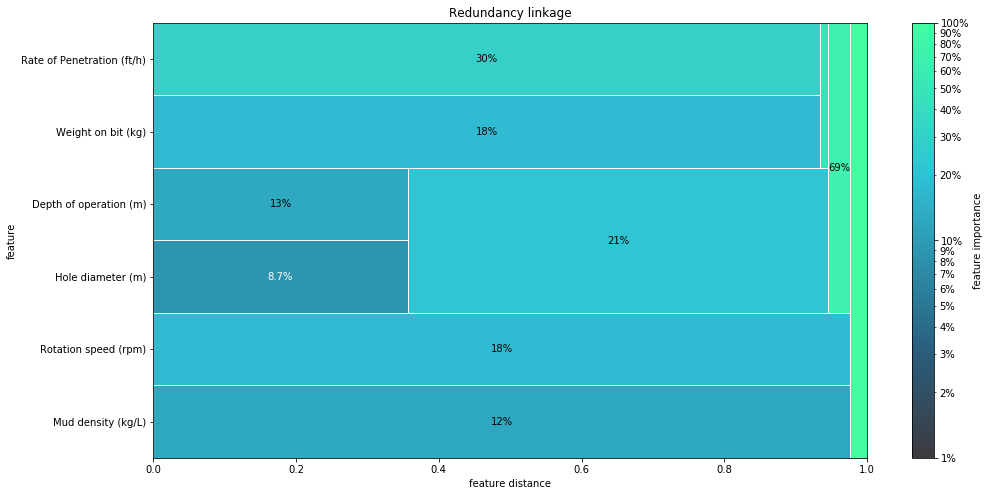

In [24]:
redundancy = model_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

Now that our feature set is looking more linearly independent, we can start making simulations to gain knowledge into how Rate of Penetration will impact failure likelihood.

Note that removing the IROP has given more feature importance to the ROP, now being the most important feature.

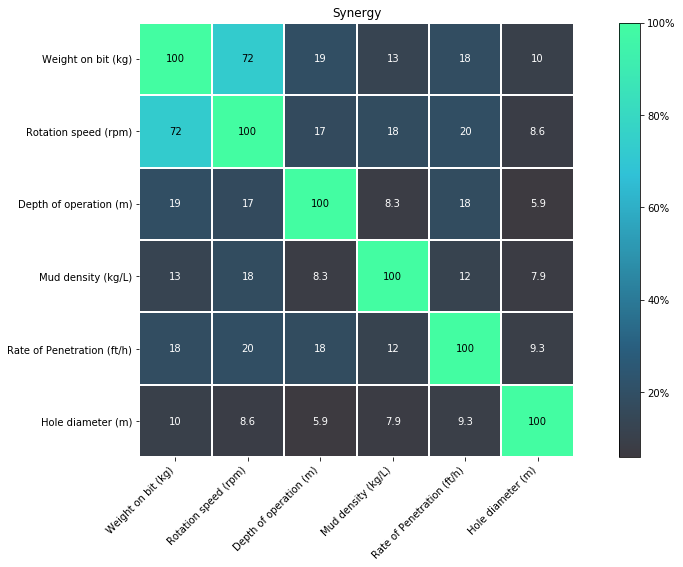

In [25]:
synergy_matrix = model_inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

Note that in our revised synergy matrix we observe a 20% synergy between ROP and the rotation speed feature, which suggests an interaction between both variables that is not expressed in our dataset. As such, some of the reproduced artificial examples may break this interaction when performing univariate simulation for ROP which may slightly impact accuracy. As the interaction is relatively low and rotation speed remains a variable with strong predictive power, we will retain it in the feature set.

# FACET univariate simulator: the impact of rate of penetration

The ROP is a parameter very much monitored while drilling a well as it is a tradeoff between safety and economy, it is safer to drill at a low pace but much costlier as it takes more time. It has also the highest feature importance in our model (see dendrogram above). Let's use a simulation to get a sense of how the failure likelihood behaves if we simulate changes in the ROP applied.

As the basis for the simulation, we divide the feature into relevant partitions: 

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of ROP into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best `LearnerCrossfit` acquired from the ranker, the simulator now re-predicts all targets using the models trained for all folds and determines the average predicted probability of the target variable resulting from this.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a matplotlib and a plain-text style


Finally, because FACET can use bootstrap cross validation, we can create a crossfit from our previous `LearnerRanker` best model to perform the simulation so we can quantify the uncertainty by using bootstrap confidence intervals.

In [26]:
# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=model_ranker.best_model_,
    cv=BootstrapCV(n_splits=1000, random_state=42),
    n_jobs=-3,
    verbose=0,
).fit(sample=drilling_obs_not_redundant)

# set-up and run a simulation
SIM_FEATURE = "Rate of Penetration (ft/h)"
rop_bins = ContinuousRangePartitioner()
rop_simulator = UnivariateProbabilitySimulator(crossfit=boot_crossfit, n_jobs=-3)
rop_simulation = rop_simulator.simulate_feature(name=SIM_FEATURE, partitioner=rop_bins)

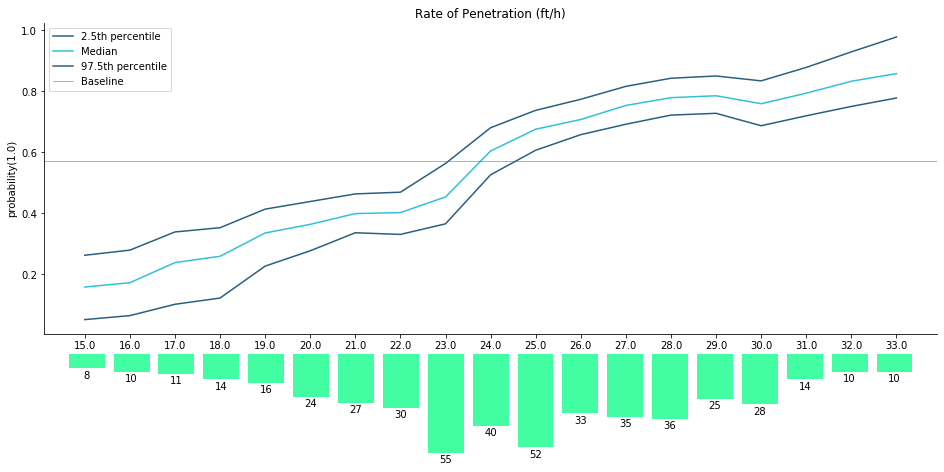

In [27]:
SimulationDrawer().draw(data=rop_simulation, title=SIM_FEATURE)

The simulation can be used to obtain insight on failure likelihood changes depending on the ROP applied. As an example, the simulation suggests that operating with an ROP above 28ft/h can lead to an incident likelihood above 70%.

# Appendix

## Dataset

For the sake of simplicity, we use a simplified artificial dataset, it contains 500 observations, each row representing a drilling operation of the past, the target is the occurrence of drill breakdown (incident).

# additional imports
from scipy.linalg import toeplitz
from sklearn.preprocessing import MinMaxScaler
from typing import Union

In [28]:
# additional imports
from scipy.linalg import toeplitz
from sklearn.preprocessing import MinMaxScaler
from typing import Union

In [29]:
def data_sim(n=100,
             intercept=-5,
             linear_vars=10,
             noise_vars=0,
             corr_vars=0,
             corr_type="AR1",
             corr_value=0,
             mislabel=0,
             surg_err=0.05,
             bin_var_p=0,
             bin_coef=0,
             outcome="classification",
             regression_err=None,
             drilling_ex=False
             ):
    """
    This function is for the most part a direct translation of the twoClassSim function from the R package caret.
    Full credit for the approach used for simulating binary classification data foes to the Authors and contributors
    of caret.

    There are some modifications from the R implementation:
    1. The ordinal outcome option has not been translated
    2. The addition of another linear feature that is a copy of another used in the linear predictor with a small amount
    of noise has been added to allow for the study of variable surrogacy
    3. Option for a binary predictor and surrogate has also been added
    4. Toggle option for regression versus classification has also been added

    Source:
        Caret: Kuhn, M. (2008). Caret package. Journal of Statistical Software, 28(5)
        https://rdrr.io/cran/caret/man/twoClassSim.html

    :param n: number of observations
    :param intercept: value for the intercept which can be modified to generate class imbalance
    :param linear_vars: number of linear features
    :param noise_vars: number of noise features (i.e., do not contribute to the linear predictor)
    :param corr_vars: number of correlated noise features
    :param corr_type: type of correlation (exchangeable or auto-regressive) for correlated noise features
    :param corr_value: correlation for correlated noise features
    :param mislabel: proportion of mis-labelling of target if required
    :param surg_err: degree of noise added to first linear predictor
    :param bin_var_p: prevalence for a binary feature to include in linear predictor
    :param bin_coef: coefficient for the impact of binary feature on linear predictor
    :param outcome: can be either classification for a binary outcome or regression for a continuous outcome
    :param regression_err: the error to be used in simulating a regression outcome
    :param drilling_ex: flag to aplly specific modifications too the function
    :return: data frame containing the simulated features and target for classification

    """

    # set seed
    np.random.seed(seed=4763546)

    # add two correlated normal features
    sigma = np.array([[1, 0], [0, 1]]) #(0s on the diagonal, 1.3 to 0, make the features independant) covariance matrix
    mu = [0, 0]
    tmp_data = pd.DataFrame(np.random.multivariate_normal(mu, sigma, size=n), columns=["TwoFactor1", "TwoFactor2"])

    # add linear features
    if linear_vars > 0:
        lin_cols = ['Linear' + str(x) for x in range(1, linear_vars + 1)]
        tmp_data = pd.concat([tmp_data, pd.DataFrame(np.random.normal(size=(n, linear_vars)), columns=lin_cols)],
                             axis=1)

    # add features for non-linear terms
    tmp_data['Nonlinear1'] = pd.Series(np.random.uniform(low=-1.0, high=1.0, size=n))
    tmp_data = pd.concat([tmp_data, pd.DataFrame(np.random.uniform(size=(n, 2)), columns=['Nonlinear2', 'Nonlinear3'])],
                         axis=1)

    # add noise variables as needed
    if noise_vars > 0:
        noise_cols = ['Noise' + str(x) for x in range(1, noise_vars + 1)]
        tmp_data = pd.concat([tmp_data, pd.DataFrame(np.random.normal(size=(n, noise_vars)), columns=noise_cols)],
                             axis=1)

    # add correlated noise features
    if corr_vars > 0:
        if corr_type == "exch":
            vc = corr_value * np.ones((corr_vars, corr_vars))
            np.fill_diagonal(vc, 1)

        elif corr_type == "AR1":
            vc_values = corr_value ** np.arange(corr_vars)
            vc = toeplitz(vc_values)

        corr_cols = ['Corr' + str(x) for x in range(1, corr_vars + 1)]
        tmp_data = pd.concat([tmp_data,
                              pd.DataFrame(np.random.multivariate_normal(np.zeros(corr_vars), vc, size=n),
                                           columns=corr_cols)],
                             axis=1)

    # add a surrogate linear feature
    if linear_vars > 0:
        tmp_data['Linear1_prime'] = tmp_data['Linear1'] + np.random.normal(0, surg_err, size=n)

    # add a binary feature
    if bin_var_p > 0:
        tmp_data['Binary1'] = np.where(np.random.uniform(size=n) <= bin_var_p, 0, 1)

    # generate contributions to linear predictor 4, 4, 2 - 0,0,4 or 5 means features will have no correlations but contributions of the predictions will only have interaction 
    lp = intercept + 0 * tmp_data.TwoFactor1 + 0 * tmp_data.TwoFactor2 + 8 * tmp_data.TwoFactor1 * tmp_data.TwoFactor2 \
         + tmp_data.Nonlinear1 ** 3 + 2 * np.exp(-6 * (tmp_data.Nonlinear1 - 0.3) ** 2) + \
         2 * np.sin(np.pi * tmp_data.Nonlinear2 * tmp_data.Nonlinear3)
        

    if linear_vars > 0:
        lin_coeff = np.linspace(10, 1, num=linear_vars) / 4
        # Set some negative coefficients of linear relationship with lp
        neg_idx = [_ for _ in range(1, linear_vars, 2)]
        lin_coeff[neg_idx] = lin_coeff[neg_idx] * -1
        if drilling_ex:
            lin_coeff[2] = 4
            lp = lp + tmp_data[lin_cols[2]]*tmp_data.TwoFactor2*tmp_data.TwoFactor1*0.0
        # Add linear relationship to lp
        lp = lp + tmp_data[lin_cols].dot(lin_coeff)

    if bin_var_p > 0:
        lp = lp + bin_coef * tmp_data['Binary1']
        tmp_data['Binary1_prime'] = 1 - tmp_data['Binary1']

    if outcome == 'classification':

        # convert to a probability
        prob = 1 / (1 + np.exp(-lp))

        # add mislabelling if desired - TO DO: need to fix
        if (mislabel > 0) and (mislabel < 1):
            shuffle_rows = np.random.choice(n, np.floor(n * mislabel), replace=False)
            prob[shuffle_rows] = 1 - prob[shuffle_rows]

        # generate target using a random threshold based on a gaussian distrib between 0 and 1
        tmp_data['target'] = np.where(prob <= np.random.uniform(size=n), 0, 1)

    elif outcome == 'regression':

        # continuous outcome based on linear predictor
        tmp_data['target'] = np.random.normal(lp, regression_err, size=n)

    return tmp_data

In [30]:
def scale_var(df: pd.DataFrame, 
              feature_name: str, 
              min_: Union[int, float]=0, 
              max_: Union[int, float]=1) -> np.array: 
    """
    Takes in a data frame and applies a min-max scaler to given bounds for a single column
    """
    
    scaler = MinMaxScaler(feature_range=(min_, max_))
    scaled_arr = scaler.fit_transform(df[[feature_name]]).reshape(1, -1)[0]
    
    return scaled_arr

In [31]:
def refactor_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df.rename({ 
        "TwoFactor1": "Weight on bit (kg)", # higher weight --> higher weight will increase risks of danger 
        "TwoFactor2": "Rotation speed (rpm)", # Rotation speed of the drilling bit (too fast rotation can lead to overheating, too low rotation renders drilling mnore difficult)         
        "Linear1": "Depth of operation (m)", # lower point of the well
        "Linear1_prime": "Hole diameter (m)", # Diameter of the hole (diameter diminishes as depth increases)
        "Nonlinear1": "Mud Flow in (m3/s)", # Speed of mud circulation
        "Linear2": "Mud density (kg/L)", # need to have equal mud and soil density to avoid well collapse (formation falling in well and blocking pipe) or mud loss (mud flowing in the formation)
        "Linear3": "Rate of Penetration (ft/h)", # higher RoP will provide less time for drilling engineers to observe real time data and adjust drilling parameter set up -> leading to a higher risk of incident (but more economic to drill faster)
        "Noise1": "Temperature (C)", # Temperature at the drilling bit 
        "target": "Incident"
    }, axis=1, inplace=True)
    
    scaling_dict = { 
        'Weight on bit (kg)': [100, 500], 
        'Rotation speed (rpm)': [900, 15000],
        'Rate of Penetration (ft/h)': [10, 40],
        #'Vertical depth of operation (m)': [0, 1500], 
        'Mud density (kg/L)': [0.5, 4],
        'Hole diameter (m)': [0.5, 10], 
        'Temperature (C)': [0, 100], 
        'Depth of operation (m)': [0, 1500], 
        'Mud Flow in (m3/s)': [0, 100],
        'Incident': [0, 1]
    }

    for k,v in scaling_dict.items(): 
        df.loc[:, k] = scale_var(df, k, v[0], v[1])
        
    df["Inverse Rate of Penetration (h/ft)"] = 1/df["Rate of Penetration (ft/h)"]
        
    return df